In [1]:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from PIL import Image

%matplotlib inline
from keras.applications import ResNet50
from keras.optimizers import Adam
import cv2
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import applications
from keras.models import Model
from keras import optimizers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

In [2]:
train = pd.read_csv('/kaggle/input/hackerearth-deep-learning-challenge-holidayseason/dataset/train.csv')
train.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


Miscellaneous     2801
Christmas_Tree    1539
Jacket             640
Candle             593
Airplane           535
Snowman            361
Name: Class, dtype: int64

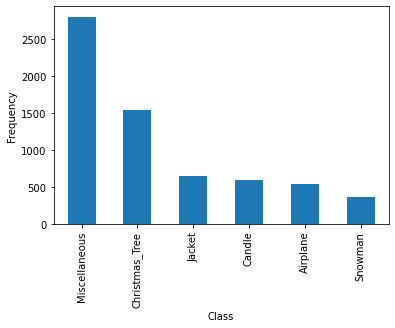

In [3]:
pd.value_counts(train['Class']).plot.bar()
plt.xlabel('Class')
plt.ylabel('Frequency')
train['Class'].value_counts()

Class_map={'Miscellaneous':0,'Christmas_Tree':1,'Jacket':2,'Candle':3,'Airplane':4,'Snowman':5}
inverse_map={0:'Miscellaneous',1:'Christmas_Tree',2:'Jacket',3:'Candle',4:'Airplane',5:'Snowman'}
train['Class']=train['Class'].map(Class_map)

In [4]:
TRAIN_PATH = '../input/hackerearth-deep-learning-challenge-holidayseason/dataset/train/'
TEST_PATH = '../input/hackerearth-deep-learning-challenge-holidayseason/dataset/test/'

In [5]:
IMG_SIZE = 64

def read_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

In [6]:
train_img = []
for img_name in tqdm(train['Image'].values):
    train_img.append(read_img(TRAIN_PATH + img_name ))
    
x_train = np.array(train_img, np.float32) / 255
print(x_train.shape)

100%|██████████| 6469/6469 [00:53<00:00, 121.27it/s]


(6469, 64, 64, 3)


In [7]:
label_list = train['Class'].tolist()
label_numeric = {k: v+1 for v, k in enumerate(set(label_list))}
y_train = [label_numeric[k] for k in label_list]
y_train = np.array(y_train)

In [8]:
y_train = to_categorical(y_train)
print(y_train.shape)

(6469, 7)


In [9]:
base_model =   applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [10]:
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dropout(0.4))
add_model.add(Dense(128, activation='relu'))
add_model.add(Dropout(0.3))
add_model.add(Dense(y_train.shape[1], activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [11]:
batch_size = 64      
epochs = 20                

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1, 
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_datagen.fit(x_train)

In [12]:
history = model.fit_generator( train_datagen.flow(x_train, y_train, batch_size=batch_size),
                               steps_per_epoch=x_train.shape[0] // batch_size,
                               epochs=epochs)

Epoch 1/20
101/101 [==============================] - 10s 98ms/step - loss: 2.5577 - accuracy: 0.3454
Epoch 2/20
101/101 [==============================] - 10s 96ms/step - loss: 1.6449 - accuracy: 0.4956
Epoch 3/20
101/101 [==============================] - 10s 103ms/step - loss: 1.3327 - accuracy: 0.5766
Epoch 4/20
101/101 [==============================] - 10s 95ms/step - loss: 1.1714 - accuracy: 0.6187
Epoch 5/20
101/101 [==============================] - 10s 103ms/step - loss: 1.0279 - accuracy: 0.6575
Epoch 6/20
101/101 [==============================] - 10s 102ms/step - loss: 0.9640 - accuracy: 0.6704
Epoch 7/20
101/101 [==============================] - 10s 96ms/step - loss: 0.9129 - accuracy: 0.6860
Epoch 8/20
101/101 [==============================] - 10s 95ms/step - loss: 0.8532 - accuracy: 0.7049
Epoch 9/20
101/101 [==============================] - 10s 102ms/step - loss: 0.8098 - accuracy: 0.7191
Epoch 10/20
101/101 [==============================] - 9s 93ms/step - loss: 0.

In [13]:
import gc
gc.collect()

28

In [14]:
test_images = os.listdir(TEST_PATH)
test_img = []
for image in test_images:
    test_img.append(read_img(TEST_PATH + image))

In [15]:
x_test = np.array(test_img, np.float32) / 255
predictions = model.predict(x_test)

In [16]:
predictions = np.argmax(predictions, axis=1)
rev_y = {v:k for k,v in label_numeric.items()}
pred_labels = [rev_y[k] for k in predictions]

In [17]:
sub = pd.DataFrame({'Image': test_images, 'Class': pred_labels})
sub.to_csv('result.csv', index = False)
sub.head()

,Image,Class
0,image7761.jpg,Miscellaneous
1,image3202.jpg,Jacket
2,image688.jpg,Snowman
3,image233.jpg,Candle
4,image4332.jpg,Christmas_Tree
